<a href="https://colab.research.google.com/github/23silicon/deep-learning/blob/main/CUDA_Accelerated_Custom_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PROJECT OVERVIEW:
# A while ago, I built a neural network in python from scratch without any ML libraries that achieves a 97.83% accuracy on MNIST after 1000 epochs.
# This project uses a matrix multiplication CUDA kernel I wrote to significantly accelerate both inference and backpropagation by parallelizing on the GPU.
# Uses Pybind11 to call the kernel (written in C++) from my network in python.

"""
On CPU:                      Training completes in 40m 4.68s
On GPU (with matmul kernel): Training completes in 16m 37.23s

Speedup: 2.411x
"""

# GPU: NVIDIA Tesla T4
# Cuda matmul kernels launched in lines 93, 169, 171 in the neural network training cell.
# TO DO for much faster training: (Once openml finally works again)
  # Implement vector addition kernel for adding result of matmul to bias vectors.
  # Replace numpy with torch tensors so copy between device and host is not needed.



#!nvidia-smi
#!nvcc --version
!pip install pybind11
!pip install ninja
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
import subprocess
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=compute_cap --format=csv,noheader,nounits")
gpu_arch = f"sm_{str.strip(gpu_info).replace('.', '')}"
print(gpu_arch)

In [ ]:
%%writefile matmul_kernel.cu
//%%cuda -c "--gpu-architecture $gpu_arch"
#include <cuda_runtime.h>

#define tilewidth 32

extern "C" {
__global__ void matrix_multiplication_kernel(const float* A, const float* B, float* C, int M, int N, int K) {
    int col = blockDim.x*blockIdx.x+threadIdx.x;
    int row = blockDim.y*blockIdx.y+threadIdx.y;

    __shared__ float Atile[tilewidth][tilewidth];
    __shared__ float Btile[tilewidth][tilewidth];


    float value = 0;
    for (int t = 0; t < (N+tilewidth-1)/tilewidth; t++) {
        int tilecol = t * tilewidth + threadIdx.x;
        int tilerow = t * tilewidth + threadIdx.y;
        Atile[threadIdx.y][threadIdx.x] = (row < M && tilecol < N) ? A[row*N + tilecol] : 0.0f;
        Btile[threadIdx.y][threadIdx.x] = (tilerow < N && col < K) ? B[tilerow*K + col] : 0.0f;

    __syncthreads();

    for (int k = 0 ; k < tilewidth; k++) {
        value += Atile[threadIdx.y][k] * Btile[k][threadIdx.x];
    }
    __syncthreads();
    }
    if (row < M && col < K) { //Final matrix is MxK
        C[row * K + col] = value;
    }
}

void launch_matmul(const float* A, const float* B, float* C, int M, int N, int K) {
  dim3 threadsPerBlock(tilewidth, tilewidth);
  dim3 blocksPerGrid((K + tilewidth - 1) / tilewidth,
                    (M + tilewidth - 1) / tilewidth);
  matrix_multiplication_kernel<<<blocksPerGrid, threadsPerBlock>>>(A, B, C, M, N, K);
  cudaDeviceSynchronize();
}

//****************************VEC ADD*************************************
//to be implemented in my network later.

__global__ void vector_add(const float* A, const float* B, float* C, int N) {
    int id = blockDim.x * blockIdx.x + threadIdx.x;
    for (int i = id; i < N; i += gridDim.x * blockDim.x) {
        C[i] = A[i] + B[i];
    }
}

void launch_vecadd(const float* A, const float* B, float* C, int N) {
    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;
    vector_add<<<blocksPerGrid, threadsPerBlock>>>(A, B, C, N);
    cudaDeviceSynchronize();
}

} //extern C

int main() {
    return 0;
}


Overwriting matmul_kernel.cu


In [ ]:
%%writefile matmul_wrapper.cpp
#include <torch/extension.h>

// Declaration of the CUDA launcher function with C linkage
extern "C" {
void launch_matmul(const float* A, const float* B, float* C, int M, int N, int K);
}

// Wrapper function called from Python
void matmul(torch::Tensor A, torch::Tensor B, torch::Tensor C, int M, int N, int K) {
    // Ensure tensors are contiguous and on CUDA
    AT_ASSERTM(A.is_cuda(), "A must be a CUDA tensor");
    AT_ASSERTM(B.is_cuda(), "B must be a CUDA tensor");
    AT_ASSERTM(C.is_cuda(), "C must be a CUDA tensor");

    const float* A_ptr = A.data_ptr<float>();
    const float* B_ptr = B.data_ptr<float>();
    float* C_ptr = C.data_ptr<float>();

    launch_matmul(A_ptr, B_ptr, C_ptr, M, N, K);
}

// Bindings to Python
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("matmul", &matmul, "Matrix multiplication CUDA kernel");
}

Overwriting matmul_wrapper.cpp


In [ ]:
from torch.utils.cpp_extension import load

matmul_module = load(
    name="matmul_cuda",
    sources=["matmul_wrapper.cpp", "matmul_kernel.cu"],
    verbose=True,
)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module matmul_cuda_v1, skipping build step...
Loading extension module matmul_cuda_v1...


In [ ]:
import torch
import numpy as np

""" code to test whether the matmul kernel works
N = 512
A_np = np.random.rand(N, N).astype(np.float32)
B_np = np.random.rand(N, N).astype(np.float32)

A = torch.from_numpy(A_np).cuda()
B = torch.from_numpy(B_np).cuda()
C = torch.empty((N, N), dtype=torch.float32, device='cuda')

matmul_module.matmul(A, B, C, 512,512,512)
C_cpu = C.cpu().numpy()
print("Result shape:", C_cpu.shape)
print(C_cpu) """

#CUDA MATMUL LAUNCHER
def launch_cuda_matmul(A, B):
    A,B = torch.from_numpy(A).cuda(),torch.from_numpy(B).cuda()
    C = torch.empty((A.shape[0], B.shape[1]), dtype=torch.float32, device='cuda')
    matmul_module.matmul(A, B, C, A.shape[0], A.shape[1], B.shape[1])
    C = C.cpu().numpy()
    return C

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time
import torch

#get mnist
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
print("Data retrieved.")
X,y = mnist['data'], mnist['target']

Encoding data...
Splitting data...
Training neural network...
Epoch 0: Accuracy = 30.59% | LR = 1.2
Epoch 10: Accuracy = 74.07% | LR = 1.2
Epoch 20: Accuracy = 81.90% | LR = 1.2
Epoch 30: Accuracy = 87.71% | LR = 1.2
Epoch 40: Accuracy = 91.89% | LR = 1.2
Epoch 50: Accuracy = 91.26% | LR = 1.2
Epoch 60: Accuracy = 93.10% | LR = 1.2
Epoch 70: Accuracy = 93.66% | LR = 1.2
Epoch 80: Accuracy = 94.04% | LR = 1.2
Epoch 90: Accuracy = 94.33% | LR = 1.2
Epoch 100: Accuracy = 94.39% | LR = 1.2
Epoch 110: Accuracy = 94.29% | LR = 1.2
Epoch 120: Accuracy = 94.91% | LR = 1.2
Epoch 130: Accuracy = 95.11% | LR = 1.2
Epoch 140: Accuracy = 95.18% | LR = 1.2
Epoch 150: Accuracy = 95.35% | LR = 1.2
Epoch 160: Accuracy = 95.51% | LR = 1.2
Epoch 170: Accuracy = 95.64% | LR = 1.2
Epoch 180: Accuracy = 95.79% | LR = 1.2
Epoch 190: Accuracy = 95.86% | LR = 1.2
Epoch 200: Accuracy = 95.98% | LR = 1.2
Epoch 210: Accuracy = 96.07% | LR = 1.2
Epoch 220: Accuracy = 96.18% | LR = 1.2
Epoch 230: Accuracy = 96.29% 

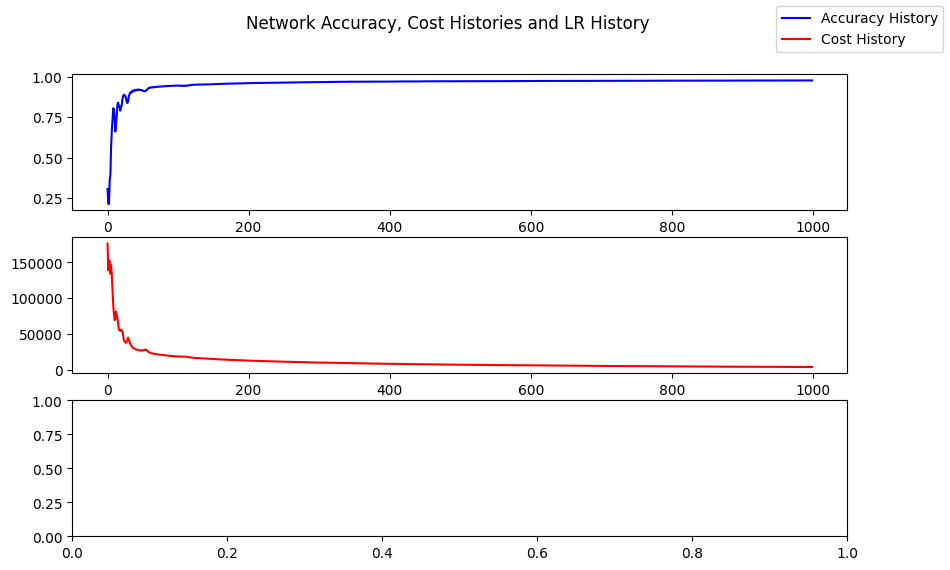

In [ ]:
"""
On CPU:                      Training completes in 40m 4.68s
On GPU (with matmul kernel): Training completes in 16m 37.23s

Speedup: 2.411x
"""

#GPU: NVIDIA Tesla T4
#Cuda matmul kernels launched in lines 93, 169, 171
#TO DO: (Once openml finally works again)
  # Implement vector addition kernel for adding result of matmul to bias vectors.
  # Replace numpy with torch tensors so copy between device and host is not needed.

class FNN_classifier:

    def __init__(self):
        self.params = {}

    def initializeParams(self, layerDims):
        #initialize weights and biases of the network given array of dimensions of each layer
        np.random.seed(42)
        for i in range(1,len(layerDims)):
            '''
                W_i is a 2 dimensional matrix that is initialized to random values with
                dimensions n*m where n is the layers in the current dimension and
                m is the layers of the previous dimension. Each value is multiplied by 0.01
                to avoid exploding gradients.
                The shape of the n*m matrix allows it to be multiplied in the current layer in
                forward propagation by the result of the previous layer which is an m-dimensional
                vector (Matrix mult: n*m x m*1). This results in an n dimensional vector that can then
                be taken to the next layer to repeat the process.

                b_i is an n dimensional vector of zeros representing biases. biases don't start
                with random values like weights do.

                Multiplication structure for a 2 by 4 weight metrix to create the linear hypothesis
                (m and n here are unrelated to previous m and n):

                [a b c d]   [i]   [m]   [o]
                [e f g h] X [j] + [n] = [p]
                            [k]
                            [l]
            '''
            self.params['W' + str(i)] = (np.random.randn(layerDims[i],layerDims[i-1])*0.1).astype(np.float32)
            self.params['b' + str(i)] = np.zeros((layerDims[i],1)).astype(np.float32)


        return self.params

    """
    ------------------------------------
    Activation functions
    """
    #Default value, can be changed
    activation = "relu"

    #functions return the value of the function given input Z and returns Z for caching
    def relu(self,Z):
        return np.maximum(0,Z), Z

    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z)), Z

    def tanh(self,Z):
        return np.tanh(Z), Z

    def softmax(self,Z):
        """
        ex. for a 3 element vector:
        Z
        """
        zexp = np.exp(Z - np.max(Z,axis=0,keepdims=True)) #Apparently this is a trick that prevents overflow
                                    #This will automatically make it so that e^largest value = e^0 = 1
                                    #This is also mathematically equivalent to regular softmax
        return zexp/np.sum(zexp, axis=0, keepdims = True), Z

    """
    ------------------------------------
    """

    def forwardProp(self,X):
        X = X.T
        #X is the incoming input matrix
        A = X
        caches = [] #stores tuples of the linear and activation caches for each layer of the network

        L = len(self.params)//2 #self.params is twice as long as the number of layers due to W_i and b_i

        for i in range(1, L+1):
            prevA = A

            #Z = Wx + b - "linear hypothesis"
            Z = launch_cuda_matmul(self.params['W' + str(i)],prevA) + self.params['b' + str(i)]                         # CUDA REPLACEMENT 1 --------------------------------

            #Caching important values from linear hypothesis
            linearCache = (prevA, self.params['W' + str(i)], self.params['b' + str(i)])

            #Caching important values from activation. Activation function returns the
            #value of the function itself and the input Z, the result of the linear hypothesis

            func = 0
            if i == L: #This is the final layer, where softmax is implemented.
                func = self.softmax(Z)
                #print(f"final layer reached, softmaxed. {L}")
            elif self.activation == "relu":
                #print(f"relu'd{L}")
                func = self.relu(Z)
            elif self.activation == "sigmoid":
                func = self.sigmoid(Z)
            elif self.activation == "tanh":
                func = self.tanh(Z)

            A, activationCache = func

            cache = (linearCache,activationCache)
            caches.append(cache)

        return A, caches


    #Now that forward propagation is done, the loss function needs to be defined
    def crossEntropyLoss(self, yTrue, yPred):
        yTrue = yTrue.T
        """
        Computes cost function for general cross entropy loss, used for multiclass classification
        """
        #accounts for floating point inaccuracies, keeps values between 0 and 1
        yPred = np.clip(yPred, 1e-15, 1-1e-15)

        #returns a vector of the individual sample losses

        losses = -np.sum(yTrue*np.log(yPred),axis=0)

        #Determines total cost by taking the average of the loss across the entire dataset.
        cost = np.mean(losses)
        return cost


    #Backprop helper function that runs it for a single layer
    def stepBack(self, dA, cache, isOutput = False):
        #dA is the gradient of the loss with respect to A, dL/dA
        #unpacking cache
        linearCache, activationCache = cache
        prevA, W, b = linearCache
        Z = activationCache
        m = prevA.shape[1] #gets number of samples


        if isOutput:
            dZ = dA
        else:
            if self.activation == "relu":
                dZ = dA * (Z>0) #Interestingly enough, you can multiply numbers by booleans in python.
                #This multiplies dA by the derivative of relu which is 1 if positive and 0 if not.
            elif self.activation == "tanh":
                dZ = dA * (1-np.tanh(Z)**2)
                #for y = tanh(x), dy/dx = 1-tanh(x)^2
            elif self.activation == "sigmoid":
                dZ = dA*self.sigmoid(Z)*(1-self.sigmoid(Z))
                #for y = sigmoid(x), dy/dx = sigmoid(x)*(1-sigmoid(x))
            else:
                raise ValueError("Activation function not supported")

        #Now, we can compute gradients for W, b, and prevA
        """print("dZ.shape", dZ.shape, "contig?", dZ.flags['C_CONTIGUOUS'])
        print("prevA.T.shape", prevA.T.shape, "contig?", prevA.T.flags['C_CONTIGUOUS'])
        print("W.T.shape", W.T.shape, "contig?", W.T.flags['C_CONTIGUOUS'])"""

        dW = (1/m)*launch_cuda_matmul(np.ascontiguousarray(dZ),np.ascontiguousarray(prevA.T))                              #CUDA REPLACEMENT 2 (88 160 162) -------------------
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        prevdA = launch_cuda_matmul(np.ascontiguousarray(W.T), np.ascontiguousarray(dZ))                                   #CUDA REPLACEMENT 3 --------------------------------

        return prevdA, dW, db

    #Now that the stepback function is defined for each layer going backwards, we can do backprop
    def backprop(self, AL, yPred, caches):
        grads = {}
        L = len(caches)

        m = AL.shape[1]
        #Remember, AL is the final activations for every sample represented as a matrix of column vectors
        '''
        ex.      [p0a p0b p0c p0d p0e]
                 [p1a p1b p1c p1d p1e]
                 [p2a p2b p2c p2d p2e]
                 [p3a p3b p3c p3d p3e]
                 [p4a p4b p4c p4d p4e]
        Where each final letter of a term represents a different sample. AL.shape[1] returns the number of columns,
        also the number of samples.
        '''
        yPred = yPred.T

        dAL = AL - yPred
        #Gradient of the loss function with respect to AL for general cross entropy loss.

        currentCache = caches[L-1]
        grads['dA' + str(L-1)], grads['dW' + str(L-1)], grads['db' + str(L-1)] = self.stepBack(dAL, currentCache, isOutput=True)

        for i in reversed(range(L-1)):
            currentCache = caches[i]
            prevdAtemp, dWtemp, dbtemp = self.stepBack(grads['dA' + str(i+1)], currentCache)

            grads['dA' + str(i)] = prevdAtemp
            #i+1 is used in order to match up the dA gradient used to calculate the weights and biases
            #of the following layer.
            grads['dW' + str(i)] = dWtemp
            grads['db' + str(i)] = dbtemp
#        print(grads.keys())
        return grads

    #Now its time for gradient descent!!! Actually updating the weights and biases according to calculated
    #grads and the learning rate, a hyperparameter.
    '''
    The learning rate hyperparameter exists to facilitate the size of steps in gradient descent.
    If the learning rate is too small, convergence to a local minimum takes too long.
    If the learning rate is too big, the process can overshoot and diverge, not reaching the minimum.
    '''
    #Also, we don't know when a minimum is reached, we just try to get close. More epochs exist to try
    #and approach the minimum of the cost function.
    '''
    Many optimizers use dynamic learning rates, decreasing step size as a minimum seems to be approached
    to get a more accurate estimate without overshooting.
    '''
    def updateParameters(self, grads, learningRate):
        L = len(self.params) // 2 #layer number

#        print(L)
        for i in range(L):
            #starting with first hidden layer updating current Weights



            self.params['W'+str(i+1)] = self.params['W'+str(i+1)] - learningRate*grads['dW'+str(i)]
            #then biases
            self.params['b'+str(i+1)] = self.params['b'+str(i+1)] - learningRate*grads['db'+str(i)]

            '''
            W_new = W - lr*grad_b
            b_new = b - lr*grad_b

            What it looks like to me is a steeper negative gradient will increase a weight ot a bias
            while a positive gradient value decreases the weight or the bias.

            A positive gradient means that increasing that parameter would increase the cost
            (if we consider partial derivative of the cost function with respect to weights or biases),
            so we decrease a weight associated with a positive gradient. Negative gradients decrease the cost
            so we increase those weights to emphasize them more.
            '''

    #Now the function must be trained.
    X_TEST = None
    Y_TEST = None
    accHistory = []
    lrHist = []
    def train(self, X, y, layerDims, epochs, learningRate, runOptimizer = True):

        params = self.initializeParams(layerDims)
        costHistory = []
        accSlopes = []
        for i in range(epochs):
            Y_hat, caches = self.forwardProp(X)
            cost = self.crossEntropyLoss(Y_hat,y)
            costHistory.append(cost)
            grads = self.backprop(Y_hat, y, caches)

            params = self.updateParameters(grads, learningRate)

            accuracy = np.mean(self.predict(FNN_classifier.X_TEST) == np.argmax(FNN_classifier.Y_TEST, axis=1))
            self.accHistory.append(accuracy)

            #Approximates derivative of the accHistory function
            if len(self.accHistory) > 1:
                accSlopes.append(self.accHistory[i]-self.accHistory[i-1])

            #running my optimizer
            if runOptimizer:
                if len(accSlopes) >= 3:
                    learningRate = self.updateLR(i, epochs, accSlopes, learningRate)
                    self.lrHist.append(learningRate)

            if i%10 == 0:
                print(f"Epoch {i}: Accuracy = {accuracy * 100:.2f}% | LR = {learningRate}")

        return params, costHistory

    def predict(self, X):
        A, _ = self.forwardProp(X)
#        print(A.shape)
        return np.argmax(A, axis=0) #return highest probability index

    #My self-designed optimizer program inspired from RMS-prop.
    def updateLR(self, i, epochs, accSlopes, learningRate):
        first = accSlopes[0]
        if first < 0:
            first = 0 - first
        lr = learningRate
        ###recentSlopeAvg = (accSlopes[i] + accSlopes[i-1] + accSlopes[i-2])/3
        #Optimization begins after certain fraction of allotted epochs is done to make sure stabilization has started.
        #For index errors, stops before last epoch.
        if epochs > 0 and i/epochs > 0.2 and i < epochs:
            if accSlopes[i-1] < accSlopes[i-2] and accSlopes[i-1] > 0:
                #decrease the learning rate proportionally to the derivative decrease but within limits 0.75 to 1.
                changeFactor = accSlopes[i-1]/first
                if changeFactor < 0.75:
                    changeFactor = 0.75
                if changeFactor > 1:
                    changeFactor = 1
                lr *= changeFactor
            if accSlopes[i-1] < 0:
                cslope = 0 - accSlopes[i-1]
                changeFactor = max(cslope,first)/min(cslope,first) #ensures >1 value
                if changeFactor < 1:
                    changeFactor = 1
                if changeFactor > 1.1:
                    changeFactor = 1.1
                lr *= changeFactor

        return lr


print("Encoding data...")

y = y.astype(int)
X = X/255.0

#one-hot encode labels in y
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(y).reshape(-1,1)) #y.shape = (70000, 10)
#X = X.T #Input format is n*m where m is samples, and current format is 70000*784. Changes to 784*70000


print("Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)


X_test = X_test.to_numpy().astype(np.float32)
y_test = y_test.astype(np.float32)
FNN_classifier.X_TEST = X_test
FNN_classifier.Y_TEST = y_test



layerDims = [784,512,10] #1 hidden layer specified. 784*256 + 256*10 = 200704 + 2560 = 203264 total weights


print("Training neural network...")

network = FNN_classifier()
network.activation = "relu" #relu, tanh, sigmoid are available


X_train = X_train.to_numpy().astype(np.float32)
y_train = y_train.astype(np.float32)

start = time.time()

params, costHistory = network.train(X_train, y_train, layerDims, epochs = 1000, learningRate = 1.2, runOptimizer=False)
#use 0.6 learning rate for fashion mnist, 1.2 for mnist
end = time.time() #times training
print(f"Training completed in {end - start} seconds.")
#Make plots to display mnist numbers and plot cost history



print("Calculating final accuracy and graphing accuracy and cost histories...")
yPred = network.predict(X_test)

#    print("Unique classes predicted:", np.unique(yPred))
print("First few predictions:\t", yPred[:35])
print("Expected labels:\t", np.argmax(y_test, axis=1)[:35])
#    print(yPred.shape)
#    print(y_test.shape)
accuracy = np.mean(yPred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100:.2f}%")

fig,axs = plt.subplots(3)
fig.suptitle('Network Accuracy, Cost Histories and LR History')
axs[0].plot(network.accHistory, label = 'Accuracy History', color = 'blue')
axs[1].plot(costHistory, label = 'Cost History', color = 'red')
#axs[2].plot(network.lrHist, label = 'LR History', color = 'green')
fig.legend()
fig.set_figheight(6)
fig.set_figwidth(10)

plt.show()





In [ ]:
import torch
import numpy as np

# Test with some sample matrices
M, N, K = 64, 128, 32 # Choose some dimensions for testing

A_np = np.random.rand(M, N).astype(np.float32)
B_np = np.random.rand(N, K).astype(np.float32)

# Perform matrix multiplication using numpy
C_np = np.dot(A_np, B_np)

# Perform matrix multiplication using your CUDA kernel
A_cuda = torch.from_numpy(A_np).cuda()
B_cuda = torch.from_numpy(B_np).cuda()
C_cuda = torch.empty((M, K), dtype=torch.float32, device='cuda')

matmul_module.matmul(A_cuda, B_cuda, C_cuda, M, N, K)
C_cuda_np = C_cuda.cpu().numpy()

# Compare the results
tolerance = 1e-5
are_close = np.allclose(C_np, C_cuda_np, atol=tolerance)

print(f"Numpy result shape: {C_np.shape}")
print(f"CUDA kernel result shape: {C_cuda_np.shape}")
print(f"Are the results from NumPy and CUDA kernel close? {are_close}")

if not are_close:
    print("\nDiscrepancies found. Let's look at a small section of the results:")
    print("NumPy result (first 5x5):\n", C_np[:5, :5])
    print("CUDA kernel result (first 5x5):\n", C_cuda_np[:5, :5])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time

class FNN_classifier:

    def __init__(self):
        self.params = {}

    def initializeParams(self, layerDims):
        #initialize weights and biases of the network given array of dimensions of each layer
        np.random.seed(42)
        for i in range(1,len(layerDims)):
            '''
                W_i is a 2 dimensional matrix that is initialized to random values with
                dimensions n*m where n is the layers in the current dimension and
                m is the layers of the previous dimension. Each value is multiplied by 0.01
                to avoid exploding gradients.
                The shape of the n*m matrix allows it to be multiplied in the current layer in
                forward propagation by the result of the previous layer which is an m-dimensional
                vector (Matrix mult: n*m x m*1). This results in an n dimensional vector that can then
                be taken to the next layer to repeat the process.

                b_i is an n dimensional vector of zeros representing biases. biases don't start
                with random values like weights do.

                Multiplication structure for a 2 by 4 weight metrix to create the linear hypothesis
                (m and n here are unrelated to previous m and n):

                [a b c d]   [i]   [m]   [o]
                [e f g h] X [j] + [n] = [p]
                            [k]
                            [l]
            '''
            self.params['W' + str(i)] = np.random.randn(layerDims[i],layerDims[i-1])*0.1
            self.params['b' + str(i)] = np.zeros((layerDims[i],1))


        return self.params

    """
    ------------------------------------
    Activation functions
    """
    #Default value, can be changed
    activation = "relu"

    #functions return the value of the function given input Z and returns Z for caching
    def relu(self,Z):
        return np.maximum(0,Z), Z

    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z)), Z

    def tanh(self,Z):
        return np.tanh(Z), Z

    def softmax(self,Z):
        """
        ex. for a 3 element vector:
        Z
        """
        zexp = np.exp(Z - np.max(Z,axis=0,keepdims=True)) #Apparently this is a trick that prevents overflow
                                    #This will automatically make it so that e^largest value = e^0 = 1
                                    #This is also mathematically equivalent to regular softmax
        return zexp/np.sum(zexp, axis=0, keepdims = True), Z

    """
    ------------------------------------
    """

    def forwardProp(self,X):
        X = X.T
        #X is the incoming input matrix
        A = X
        caches = [] #stores tuples of the linear and activation caches for each layer of the network

        L = len(self.params)//2 #self.params is twice as long as the number of layers due to W_i and b_i

        for i in range(1, L+1):
            prevA = A

            #Z = Wx + b - "linear hypothesis"

            Z = np.dot(self.params['W' + str(i)],prevA) + self.params['b' + str(i)]

            #Caching important values from linear hypothesis
            linearCache = (prevA, self.params['W' + str(i)], self.params['b' + str(i)])

            #Caching important values from activation. Activation function returns the
            #value of the function itself and the input Z, the result of the linear hypothesis

            func = 0
            if i == L: #This is the final layer, where softmax is implemented.
                func = self.softmax(Z)
                #print(f"final layer reached, softmaxed. {L}")
            elif self.activation == "relu":
                #print(f"relu'd{L}")
                func = self.relu(Z)
            elif self.activation == "sigmoid":
                func = self.sigmoid(Z)
            elif self.activation == "tanh":
                func = self.tanh(Z)

            A, activationCache = func

            cache = (linearCache,activationCache)
            caches.append(cache)

        return A, caches


    #Now that forward propagation is done, the loss function needs to be defined
    def crossEntropyLoss(self, yTrue, yPred):
        yTrue = yTrue.T
        """
        Computes cost function for general cross entropy loss, used for multiclass classification
        """
        #accounts for floating point inaccuracies, keeps values between 0 and 1
        yPred = np.clip(yPred, 1e-15, 1-1e-15)

        #returns a vector of the individual sample losses

        losses = -np.sum(yTrue*np.log(yPred),axis=0)

        #Determines total cost by taking the average of the loss across the entire dataset.
        cost = np.mean(losses)
        return cost


    #Backprop helper function that runs it for a single layer
    def stepBack(self, dA, cache, isOutput = False):
        #dA is the gradient of the loss with respect to A, dL/dA
        #unpacking cache
        linearCache, activationCache = cache
        prevA, W, b = linearCache
        Z = activationCache
        m = prevA.shape[1] #gets number of samples


        if isOutput:
            dZ = dA
        else:
            if self.activation == "relu":
                dZ = dA * (Z>0) #Interestingly enough, you can multiply numbers by booleans in python.
                #This multiplies dA by the derivative of relu which is 1 if positive and 0 if not.
            elif self.activation == "tanh":
                dZ = dA * (1-np.tanh(Z)**2)
                #for y = tanh(x), dy/dx = 1-tanh(x)^2
            elif self.activation == "sigmoid":
                dZ = dA*self.sigmoid(Z)*(1-self.sigmoid(Z))
                #for y = sigmoid(x), dy/dx = sigmoid(x)*(1-sigmoid(x))
            else:
                raise ValueError("Activation function not supported")

        #Now, we can compute gradients for W, b, and prevA
        dW = (1/m)*np.dot(dZ,prevA.T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        prevdA = np.dot(W.T, dZ)

        return prevdA, dW, db

    #Now that the stepback function is defined for each layer going backwards, we can do backprop
    def backprop(self, AL, yPred, caches):
        grads = {}
        L = len(caches)

        m = AL.shape[1]
        #Remember, AL is the final activations for every sample represented as a matrix of column vectors
        '''
        ex.      [p0a p0b p0c p0d p0e]
                 [p1a p1b p1c p1d p1e]
                 [p2a p2b p2c p2d p2e]
                 [p3a p3b p3c p3d p3e]
                 [p4a p4b p4c p4d p4e]
        Where each final letter of a term represents a different sample. AL.shape[1] returns the number of columns,
        also the number of samples.
        '''
        yPred = yPred.T

        dAL = AL - yPred
        #Gradient of the loss function with respect to AL for general cross entropy loss.

        currentCache = caches[L-1]
        grads['dA' + str(L-1)], grads['dW' + str(L-1)], grads['db' + str(L-1)] = self.stepBack(dAL, currentCache, isOutput=True)

        for i in reversed(range(L-1)):
            currentCache = caches[i]
            prevdAtemp, dWtemp, dbtemp = self.stepBack(grads['dA' + str(i+1)], currentCache)

            grads['dA' + str(i)] = prevdAtemp
            #i+1 is used in order to match up the dA gradient used to calculate the weights and biases
            #of the following layer.
            grads['dW' + str(i)] = dWtemp
            grads['db' + str(i)] = dbtemp
#        print(grads.keys())
        return grads

    #Now its time for gradient descent!!! Actually updating the weights and biases according to calculated
    #grads and the learning rate, a hyperparameter.
    '''
    The learning rate hyperparameter exists to facilitate the size of steps in gradient descent.
    If the learning rate is too small, convergence to a local minimum takes too long.
    If the learning rate is too big, the process can overshoot and diverge, not reaching the minimum.
    '''
    #Also, we don't know when a minimum is reached, we just try to get close. More epochs exist to try
    #and approach the minimum of the cost function.
    '''
    Many optimizers use dynamic learning rates, decreasing step size as a minimum seems to be approached
    to get a more accurate estimate without overshooting.
    '''
    def updateParameters(self, grads, learningRate):
        L = len(self.params) // 2 #layer number

#        print(L)
        for i in range(L):
            #starting with first hidden layer updating current Weights



            self.params['W'+str(i+1)] = self.params['W'+str(i+1)] - learningRate*grads['dW'+str(i)]
            #then biases
            self.params['b'+str(i+1)] = self.params['b'+str(i+1)] - learningRate*grads['db'+str(i)]

            '''
            W_new = W - lr*grad_b
            b_new = b - lr*grad_b

            What it looks like to me is a steeper negative gradient will increase a weight ot a bias
            while a positive gradient value decreases the weight or the bias.

            A positive gradient means that increasing that parameter would increase the cost
            (if we consider partial derivative of the cost function with respect to weights or biases),
            so we decrease a weight associated with a positive gradient. Negative gradients decrease the cost
            so we increase those weights to emphasize them more.
            '''

    #Now the function must be trained.
    X_TEST = None
    Y_TEST = None
    accHistory = []
    lrHist = []
    def train(self, X, y, layerDims, epochs, learningRate, runOptimizer = True):

        params = self.initializeParams(layerDims)
        costHistory = []
        accSlopes = []
        for i in range(epochs):
            Y_hat, caches = self.forwardProp(X)
            cost = self.crossEntropyLoss(Y_hat,y)
            costHistory.append(cost)
            grads = self.backprop(Y_hat, y, caches)

            params = self.updateParameters(grads, learningRate)

            accuracy = np.mean(self.predict(FNN_classifier.X_TEST) == np.argmax(FNN_classifier.Y_TEST, axis=1))
            self.accHistory.append(accuracy)

            #Approximates derivative of the accHistory function
            if len(self.accHistory) > 1:
                accSlopes.append(self.accHistory[i]-self.accHistory[i-1])

            #running my optimizer
            if runOptimizer:
                if len(accSlopes) >= 3:
                    learningRate = self.updateLR(i, epochs, accSlopes, learningRate)
                    self.lrHist.append(learningRate)

            if i%2 == 0:
                print(f"Epoch {i}: Accuracy = {accuracy * 100:.2f}% | LR = {learningRate}")

        return params, costHistory

    def predict(self, X):
        A, _ = self.forwardProp(X)
#        print(A.shape)
        return np.argmax(A, axis=0) #return highest probability index

    #My self-designed optimizer program inspired from RMS-prop.
    def updateLR(self, i, epochs, accSlopes, learningRate):
        first = accSlopes[0]
        if first < 0:
            first = 0 - first
        lr = learningRate
        ###recentSlopeAvg = (accSlopes[i] + accSlopes[i-1] + accSlopes[i-2])/3
        #Optimization begins after certain fraction of allotted epochs is done to make sure stabilization has started.
        #For index errors, stops before last epoch.
        if epochs > 0 and i/epochs > 0.2 and i < epochs:
            if accSlopes[i-1] < accSlopes[i-2] and accSlopes[i-1] > 0:
                #decrease the learning rate proportionally to the derivative decrease but within limits 0.75 to 1.
                changeFactor = accSlopes[i-1]/first
                if changeFactor < 0.75:
                    changeFactor = 0.75
                if changeFactor > 1:
                    changeFactor = 1
                lr *= changeFactor
            if accSlopes[i-1] < 0:
                cslope = 0 - accSlopes[i-1]
                changeFactor = max(cslope,first)/min(cslope,first) #ensures >1 value
                if changeFactor < 1:
                    changeFactor = 1
                if changeFactor > 1.1:
                    changeFactor = 1.1
                lr *= changeFactor

        return lr

#get mnist
print("Loading MNIST dataset...")
mnist = fetch_openml('Fashion-MNIST', version=1)
X,y = mnist['data'], mnist['target']

print("Encoding data...")

y = y.astype(int)
X = X/255.0

#one-hot encode labels in y
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(y).reshape(-1,1)) #y.shape = (70000, 10)
#X = X.T #Input format is n*m where m is samples, and current format is 70000*784. Changes to 784*70000


print("Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

FNN_classifier.X_TEST = X_test
FNN_classifier.Y_TEST = y_test



layerDims = [784,512,10] #1 hidden layer specified. 784*256 + 256*10 = 200704 + 2560 = 203264 total weights


print("Training neural network...")

network = FNN_classifier()
network.activation = "relu" #relu, tanh, sigmoid are available

start = time.time()
params, costHistory = network.train(X_train, y_train, layerDims, epochs = 1000, learningRate = 0.6, runOptimizer=False)
#use 0.6 learning rate for fashion mnist, 1.2 for mnist
end = time.time() #times training
print(f"Training completed in {end - start} seconds.")
#Make plots to display mnist numbers and plot cost history



print("Calculating final accuracy and graphing accuracy and cost histories...")
yPred = network.predict(X_test)

#    print("Unique classes predicted:", np.unique(yPred))
print("First few predictions:\t", yPred[:35])
print("Expected labels:\t", np.argmax(y_test, axis=1)[:35])
#    print(yPred.shape)
#    print(y_test.shape)
accuracy = np.mean(yPred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100:.2f}%")

fig,axs = plt.subplots(3)
fig.suptitle('Network Accuracy, Cost Histories and LR History')
axs[0].plot(network.accHistory, label = 'Accuracy History', color = 'blue')
axs[1].plot(costHistory, label = 'Cost History', color = 'red')
axs[2].plot(network.lrHist, label = 'LR History', color = 'green')
fig.legend()
fig.set_figheight(6)
fig.set_figwidth(10)

#display mnist digits - WIP
'''for i in range(5):
    import matplotlib.pyplot as plt2
    fig2, axs2 = plt2.subplots(5)
    plt2.imshow(X_test.to_numpy()[i].reshape(28,28), cmap='gray')
    plt2.title(f'Label: {y_test[i]}')
'''
plt.show()





Loading MNIST dataset...


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/data/v1/download/18238735. Retrying...
  warn(


HTTPError: HTTP Error 404: Not Found